In [1]:
%matplotlib inline
#data manip
import pandas as pd
import numpy as np

#data viz
from matplotlib import pyplot as plt
import seaborn as sns

#custom packages
import database_utility
import baseball_models
from pybaseball import playerid_reverse_lookup


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

Load in our database helper in case we need to pull data

In [3]:
sqlite_file = '../baseball_data.sqlite'
dh = database_utility.DatabaseHelper(sqlite_file, '../baseball_key_joiner.csv')
#This will give a ValueError when using pd.read_json if the path doesn't exist
filepath = '../../bbref_scraper/bbref.jl'

#Paths to our 2 bbref databases that need be combined
path2017='/Users/Alexandria/Desktop/Google Drive/MBA/11. Winter 2019/SI 699/bbref_scraper/bbref_scraper/bbref.jl'
path2018='/Users/Alexandria/Desktop/Google Drive/MBA/11. Winter 2019/SI 699/bbref_2018.jl'

# Batting DF 

### We need batting_df so we can FE off of it, if we FE off rotoguru data there are too many columns and it won't work

In [4]:
#i exclude the last 2 months of the season which is validation data
batting_df = dh.calc_batting_fd_score(start_date = '2015-04-01', 
                                      end_date = '2018-12-31', 
                                      path2017 = path2017,
                                      path2018 = path2018,
                                      write_csv = True,
                                      preload=False)

Reading in data..
Parsing raw dictionaries to get stats...
Cleaning dates...
Converting stats columns to numeric...
Raw data returned!
Reading in data..
Parsing raw dictionaries to get stats...
Cleaning dates...
Converting stats columns to numeric...
Raw data returned!
Accessing statcast_cache...
If dates are missing try rebuilding cache...
Gathering player lookup table. This may take a moment.
Aggregating data...
Merging bbref and statcast data...
Batting FD Score calculated! Returning data..


### Create features, batting_df is the host and must be used as target for feature generation

In [5]:
import baseball_models
fe = baseball_models.FeatureEngineer(df=batting_df)

In [6]:
#%%time
# avg 16 seconds
life_avgs = fe.calc_lifetime_avg()

In [7]:
#%%time
# avg 40 seconds
rolling_avgs = fe.calc_rolling_avg()

In [8]:
#%%time
# avg 1 minute
ytd_avgs = fe.calc_ytd_avgs()

#### Calculate stadium batting average 

* Calling the function again with a "switch_cutoff" value 0.01 - 0.50 indicates the value at which a batter is considered to by ambidexterous.  For example, 70 left handed batting events and 30 right handed batting events means a 30% switch rate.  This would change the percentages slightly for individual player performance.

In [11]:
stad_avg = fe.stadium_stats(ballpark_stat_path='ballpark_handed_stats.csv', 
                            ballpark_key_path='../baseball_key_joiner.csv')
stad_avg.head()

,game_id,stadium_BA,stadium_OBP,stadium_SLG,stadium_OPS,stadium_BAbip
0,2015-07-04SunTrust Parkaardsda01,0.245,0.307,0.365,0.672,0.304
1,2015-07-04SunTrust Parkaardsda01,0.265,0.348,0.407,0.755,0.305
2,2015-07-04SunTrust Parkaardsda01,0.256,0.347,0.419,0.766,0.303
3,2015-07-04SunTrust Parkaardsda01,0.269,0.300,0.346,0.646,0.292
4,2016-04-24Nationals Parkabadfe01,0.262,0.326,0.437,0.764,0.319


### Location - Time - Day of Week Dummy Variables

Extract using pd.get_dummies and include as features

This SO link was helpful: https://stackoverflow.com/questions/34265102/xgboost-categorical-variables-dummification-vs-encoding

https://www.purplerow.com/2018/1/8/16846116/colorado-rockies-coors-field-arizona-diamondbacks-chase-field-comparison

In [12]:
loc_time_day_frame = fe.stadium_dummies()
loc_time_day_frame.head(2)

,game_id,game_situation_,"game_situation_: 22,640",game_situation_: 3:17,game_situation_: 3:49,"game_situation_Day Game, on grass","game_situation_Day Game, on turf","game_situation_First game of doubleheader, see","game_situation_Friday, September 28, 2018","game_situation_Night Game, on grass","game_situation_Night Game, on turf",team_home,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,stadium_Busch Stadium,stadium_Chase Field,stadium_Citi Field,stadium_Citizens Bank Park,stadium_Comerica Park,stadium_Coors Field,stadium_Dodger Stadium,stadium_Fenway Park,stadium_Globe Life Park in Arlington,stadium_Great American Ball Park,stadium_Guaranteed Rate Field,stadium_Kauffman Stadium,stadium_Marlins Park,stadium_Miller Park,stadium_Minute Maid Park,stadium_Nationals Park,stadium_Oakland Alameda County Coliseum,stadium_Oracle Park,stadium_Oriole Park at Camden Yards,stadium_PNC Park,stadium_Petco Park,stadium_Progressive Field,stadium_Rogers Centre,stadium_SunTrust Park,stadium_T-Mobile Park,stadium_Target Field,stadium_Tropicana Field,stadium_Wrigley Field,stadium_Yankee Stadium
70989,2015-07-04SunTrust Parkaardsda01,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
97402,2016-04-24Nationals Parkabadfe01,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Pitcher Frame Join ** Not yet functional, ignore

In [9]:
#pitch_features = pd.read_csv('pitch_feature_df.csv')

### Test later - drop double game situations and just take the first one

### Batting Frame Join

In [13]:
bat_features = pd.read_csv('bat_feature_df.csv')

In [18]:
feature_frame2 = batting_df.merge(bat_features, how="left", left_on="roto_game_id", right_on="roto_game_id", indicator=False, validate="m:1")

In [19]:
feature_frame2.to_csv('batter_roto_frame.csv', index=False)

### Player Differences

### Other Differences

## Merging roto_batting_frame with features

In [62]:
roto_batting_frame = pd.read_csv('batter_roto_frame.csv')

In [63]:
roto_batting_frame.head(2)

,game_id,away_team,home_team,game_date,start_time,attendance,game_situation,player,team,AB,R,H,RBI,BB,SO,PA,batting_avg,onbase_perc,slugging_perc,onbase_plus_slugging,pitches,strikes_total,wpa_bat,leverage_index_avg,wpa_bat_pos,wpa_bat_neg,re24_bat,PO,A,details,position,day_of_week,year,stadium,batter,hit_by_pitch,home_run,single,double,triple,walk,fd_score,roto_game_id,AB_lifeavg,R_lifeavg,H_lifeavg,RBI_lifeavg,BB_lifeavg,SO_lifeavg,PA_lifeavg,batting_avg_lifeavg,onbase_perc_lifeavg,slugging_perc_lifeavg,onbase_plus_slugging_lifeavg,pitches_lifeavg,strikes_total_lifeavg,wpa_bat_lifeavg,leverage_index_avg_lifeavg,wpa_bat_pos_lifeavg,wpa_bat_neg_lifeavg,re24_bat_lifeavg,PO_lifeavg,A_lifeavg,AB_7dayavg,AB_14dayavg,AB_21dayavg,AB_28dayavg,AB_42dayavg,R_7dayavg,R_14dayavg,R_21dayavg,R_28dayavg,R_42dayavg,H_7dayavg,H_14dayavg,H_21dayavg,H_28dayavg,H_42dayavg,RBI_7dayavg,RBI_14dayavg,RBI_21dayavg,RBI_28dayavg,RBI_42dayavg,BB_7dayavg,BB_14dayavg,BB_21dayavg,BB_28dayavg,BB_42dayavg,SO_7dayavg,SO_14dayavg,SO_21dayavg,SO_28dayavg,SO_42dayavg,PA_7dayavg,PA_14dayavg,PA_21dayavg,PA_28dayavg,PA_42dayavg,batting_avg_7dayavg,batting_avg_14dayavg,batting_avg_21dayavg,batting_avg_28dayavg,batting_avg_42dayavg,onbase_perc_7dayavg,onbase_perc_14dayavg,onbase_perc_21dayavg,onbase_perc_28dayavg,onbase_perc_42dayavg,slugging_perc_7dayavg,slugging_perc_14dayavg,slugging_perc_21dayavg,slugging_perc_28dayavg,slugging_perc_42dayavg,onbase_plus_slugging_7dayavg,onbase_plus_slugging_14dayavg,onbase_plus_slugging_21dayavg,onbase_plus_slugging_28dayavg,onbase_plus_slugging_42dayavg,pitches_7dayavg,pitches_14dayavg,pitches_21dayavg,pitches_28dayavg,pitches_42dayavg,strikes_total_7dayavg,strikes_total_14dayavg,strikes_total_21dayavg,strikes_total_28dayavg,strikes_total_42dayavg,wpa_bat_7dayavg,wpa_bat_14dayavg,wpa_bat_21dayavg,wpa_bat_28dayavg,wpa_bat_42dayavg,leverage_index_avg_7dayavg,leverage_index_avg_14dayavg,leverage_index_avg_21dayavg,leverage_index_avg_28dayavg,leverage_index_avg_42dayavg,wpa_bat_pos_7dayavg,wpa_bat_pos_14dayavg,wpa_bat_pos_21dayavg,wpa_bat_pos_28dayavg,wpa_bat_pos_42dayavg,wpa_bat_neg_7dayavg,wpa_bat_neg_14dayavg,wpa_bat_neg_21dayavg,wpa_bat_neg_28dayavg,wpa_bat_neg_42dayavg,re24_bat_7dayavg,re24_bat_14dayavg,re24_bat_21dayavg,re24_bat_28dayavg,re24_bat_42dayavg,PO_7dayavg,PO_14dayavg,PO_21dayavg,PO_28dayavg,PO_42dayavg,A_7dayavg,A_14dayavg,A_21dayavg,A_28dayavg,A_42dayavg,AB_ytdavg,R_ytdavg,H_ytdavg,RBI_ytdavg,BB_ytdavg,SO_ytdavg,PA_ytdavg,batting_avg_ytdavg,onbase_perc_ytdavg,slugging_perc_ytdavg,onbase_plus_slugging_ytdavg,pitches_ytdavg,strikes_total_ytdavg,wpa_bat_ytdavg,leverage_index_avg_ytdavg,wpa_bat_pos_ytdavg,wpa_bat_neg_ytdavg,re24_bat_ytdavg,PO_ytdavg,A_ytdavg,ab_matchup_hist,pa_matchup_hist,slugging_perc_matchup_hist,hits_matchup_hist,batting_avg_matchup_hist,on_base_perc_matchup_hist,H/A_h,Condition_overcast,Condition_partly cloudy,Condition_cloudy,Condition_clear,Condition_sunny,Condition_drizzle,Condition_dome,Condition_rain,Condition_roof closed,Condition_unknown,Condition_snow,W_dir_In from LF,W_dir_Out to RF,W_dir_L to R,W_dir_In from CF,W_dir_R to L,W_dir_In from RF,W_dir_Out to CF,W_dir_Varies,W_dir_Out to LF,W_dir_None,W_dir_Calm,W_dir_none,Order_2.0,Order_3.0,Order_4.0,Order_5.0,Order_8.0,Order_6.0,Order_7.0,Order_9.0,Order_1.0,Order_0.0,lagged_fd_score,FD_points
0,2015-04-06Marlins Parkyounger03,Atlanta Braves,Miami Marlins,2015-04-06,4:22 p.m.,"36,969","Day Game, on grass",younger03,away,4.0,1.0,1.0,0.0,0.0,1.0,4.0,0.250,0.250,0.500,0.750,13.0,11.0,0.018,1.14,0.097,-0.079,-0.2,2,0,2B,CF-LF,Monday,2015.0,Marlins Park,458913.0,0.0,0.0,0.0,1.0,0.0,0.0,9.2,2015-04-06younger03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [65]:
roto_batting_frame = roto_batting_frame.merge(life_avgs.drop_duplicates(subset=['game_id']), 
                                              how="left", left_on="game_id", 
                                              right_on="game_id", suffixes=('', '_y'))

In [67]:
roto_batting_frame = roto_batting_frame.merge(rolling_avgs.drop_duplicates(subset=['game_id']), 
                                              how="left", left_on="game_id", 
                                              right_on="game_id", suffixes=('', '_y'))

In [69]:
roto_batting_frame = roto_batting_frame.merge(ytd_avgs.drop_duplicates(subset=['game_id']), 
                                              how="left", left_on="game_id", 
                                              right_on="game_id", suffixes=('', '_y'))

In [70]:
roto_batting_frame = roto_batting_frame.merge(stad_avg.drop_duplicates(subset=['game_id']), 
                                              how="left", left_on="game_id", 
                                              right_on="game_id", suffixes=('', '_y'))

In [71]:
roto_batting_frame = roto_batting_frame.merge(loc_time_day_frame.drop_duplicates(subset=['game_id']), 
                                              how="left", left_on="game_id", 
                                              right_on="game_id", suffixes=('', '_y'))

### We get duplicate columns (does rotoguru include features?) from the many merges, drop them all

In [77]:
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

#drop duplicate columns, all marked with _y
drop_y(roto_batting_frame)

In [79]:
roto_batting_frame.to_csv('roto_frame_with_stadium.csv', index=False)

# If you have roto_frame_with_stadium.csv START HERE

In [80]:
feature_df_b = pd.read_csv('roto_frame_with_stadium.csv')

In [84]:
print('fd_score' in feature_df_b.columns)
print('FD_points' in feature_df_b.columns)

True
True


My next step is to look at feature importance via XGBoost and SHAP values and also evaluate model performance

In [85]:
import xgboost
import baseball_models
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

cv = baseball_models.CrossValidator()

#make sure we are sorted by time (days)
feature_df_b.sort_values(by='game_id',inplace=True)

X, y, tscv = cv.train_test_split(feature_df_b.drop(['fd_score', 'FD_points'], axis=1), feature_df_b['fd_score'], num_splits=3)

#remove features that we know aren't valuable from previous feature engineering
#we can add new features that we are trying for the first time in the 'new_features parameter'
incoming_features = []
incoming_features.append(life_avgs.drop('game_id', axis=1).columns)
incoming_features.append(stad_avg.drop('game_id', axis=1).columns)
incoming_features.append(loc_time_day_frame.drop('game_id', axis=1).columns)
incoming_features.append(rolling_avgs.drop('game_id', axis=1).columns)
incoming_features.append(ytd_avgs.drop('game_id', axis=1).columns)

flat_incoming_list = [item for sublist in incoming_features for item in sublist]

fe_to_test = pd.Index(flat_incoming_list)



X = cv.clean_for_model(X, batting=True, new_features = fe_to_test)

#initialize the model
xgbreg = xgboost.XGBRegressor(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

Train the model using walk-forward cross validation

In [86]:
cv.cross_validate(X, y, tscv, xgbreg)

Running iter: 1


/Users/Alexandria/anaconda/envs/moneyball/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 1 took 47.05792284011841 seconds.
Running iter: 2


/Users/Alexandria/anaconda/envs/moneyball/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 2 took 115.47079014778137 seconds.
Running iter: 3


/Users/Alexandria/anaconda/envs/moneyball/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 3 took 160.5109941959381 seconds.


We log the model performance and top performing features, as well as the data trained on for posterity

In [39]:
#cv.log_model(notes="Trained for 10 iterations over 2015/2016 data with new lifetime features")
cv.log_model(notes="Trained for 3 iterations over 2015-2018 data with lifetime features, rolling averages, stadium values and categorical dummy variables")

In [87]:
performance_frame = pd.DataFrame({'Train':cv.train_maes, 'Test':cv.test_maes})
performance_frame.head()

,Train,Test
0,5.824087,3.703019
1,4.504074,3.327430
2,4.106775,3.183492


<h4> Model Analysis </h4>

Cross Validate uses sklearns TimeSeriesSplit to perform walk-forward cross validation for the number of splits indicated in the train_test_split function above.  I run this because I am curious if YTD features 'get better' as the year goes on.  I would expect to see the test MAE improve over the course of the year (as iterations increase)

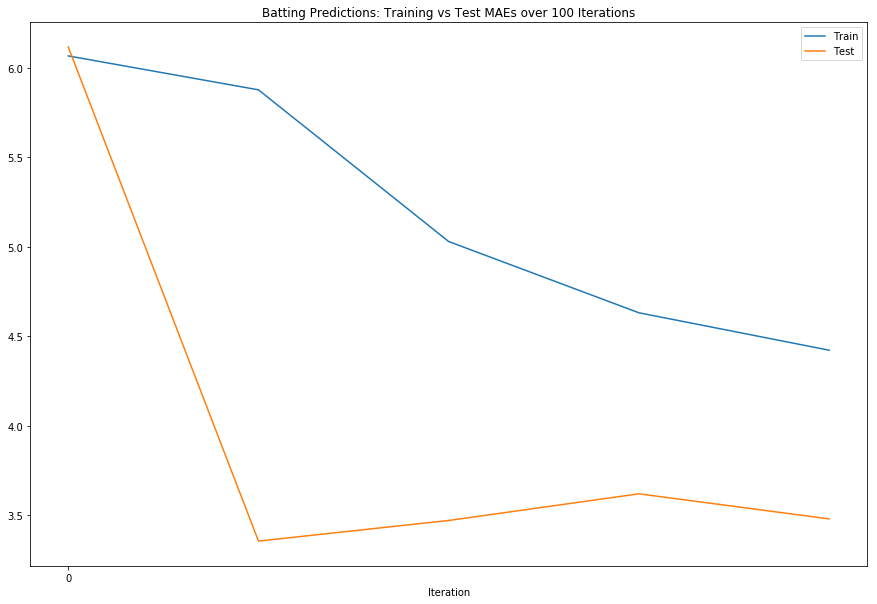

In [42]:
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(y=cv.train_maes, x=np.arange(0, len(cv.train_maes)))
ax = sns.lineplot(y=cv.test_maes, x=np.arange(0, len(cv.train_maes)), ax=ax, legend='brief')
ax.set_xticks(ticks=np.arange(0,len(cv.test_maes)+1, 10))
ax.set_xlabel(xlabel="Iteration")
ax.set_title("Batting Predictions: Training vs Test MAEs over" str(len(cv.test_maes+1))" Iterations")
ax.legend(labels=['Train','Test'])
plt.show()

It looks like there is a slight trend - let's validate that the variance in the test MAE gets less as we get farther through the year.

In [43]:
print("STDev for the first 50 iterations is: {:.2f} ".format(np.std(cv.test_maes[0:50])))
print("STDev for the last 50 iterations is: {:.2f}".format(np.std(cv.test_maes[51:100])))

STDev for the first 50 iterations is: 1.06 
STDev for the last 50 iterations is: nan


/Users/Alexandria/anaconda/envs/moneyball/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Alexandria/anaconda/envs/moneyball/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Alexandria/anaconda/envs/moneyball/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Next, I want to identify which features are actually contributing to the model's predictions using SHAP values

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83

In [42]:
batting_df['game_id'].iloc[0]

'2015-04-06Marlins Parkyounger03'

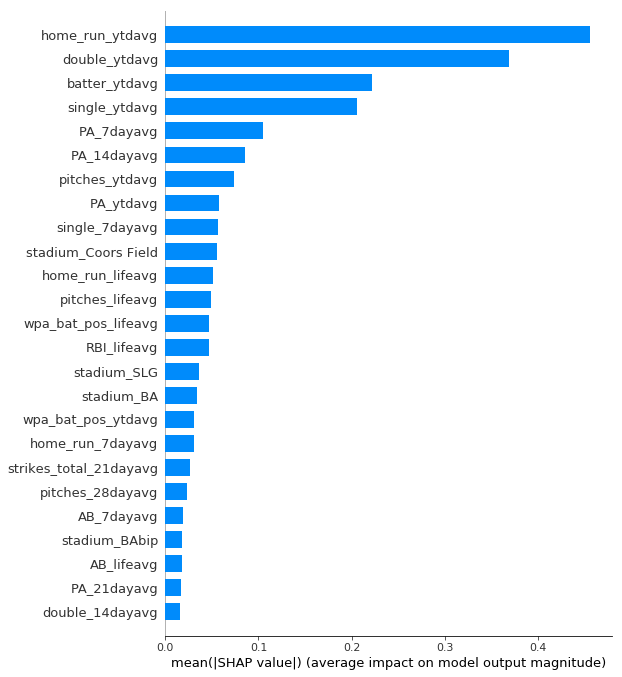

In [44]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(cv.model)
shap_values = explainer.shap_values(cv.X_train)
shap.summary_plot(shap_values, features=cv.X_train, plot_type="bar", max_display=25)

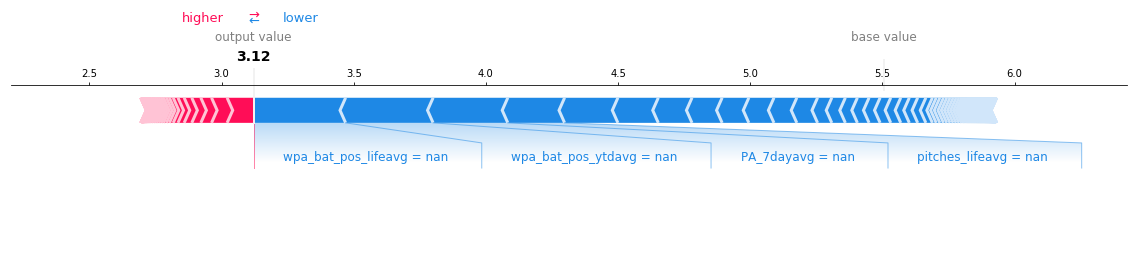

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10,:], cv.X_train.iloc[10,:], matplotlib=True)

Finally, we can validate this by looking at some reg plots - we should see linear trends in these top features that didn't necessarily show up in the correlation matrix above. 

In [46]:
#take the top 10 in SHAP values
X_train = cv.X_train.copy()
X_train['fd_score'] = cv.y_train
top_shap_b = X_train[['slugging_perc_7dayavg', 'home_run_ytdavg', 'PA_ytdavg', 'home_run_7dayavg', 'pitches_ytdavg', 'slugging_perc_21dayavg', 'AB_ytdavg', 'strikes_total_ytdavg', 're24_bat_14dayavg', 'RBI_ytdavg', 'triple_28dayavg', 'PO_28dayavg', 'hit_by_pitch_21dayavg', 'triple_7dayavg', 'BB_28dayavg', 'fd_score']]

/Users/Alexandria/anaconda/envs/moneyball/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


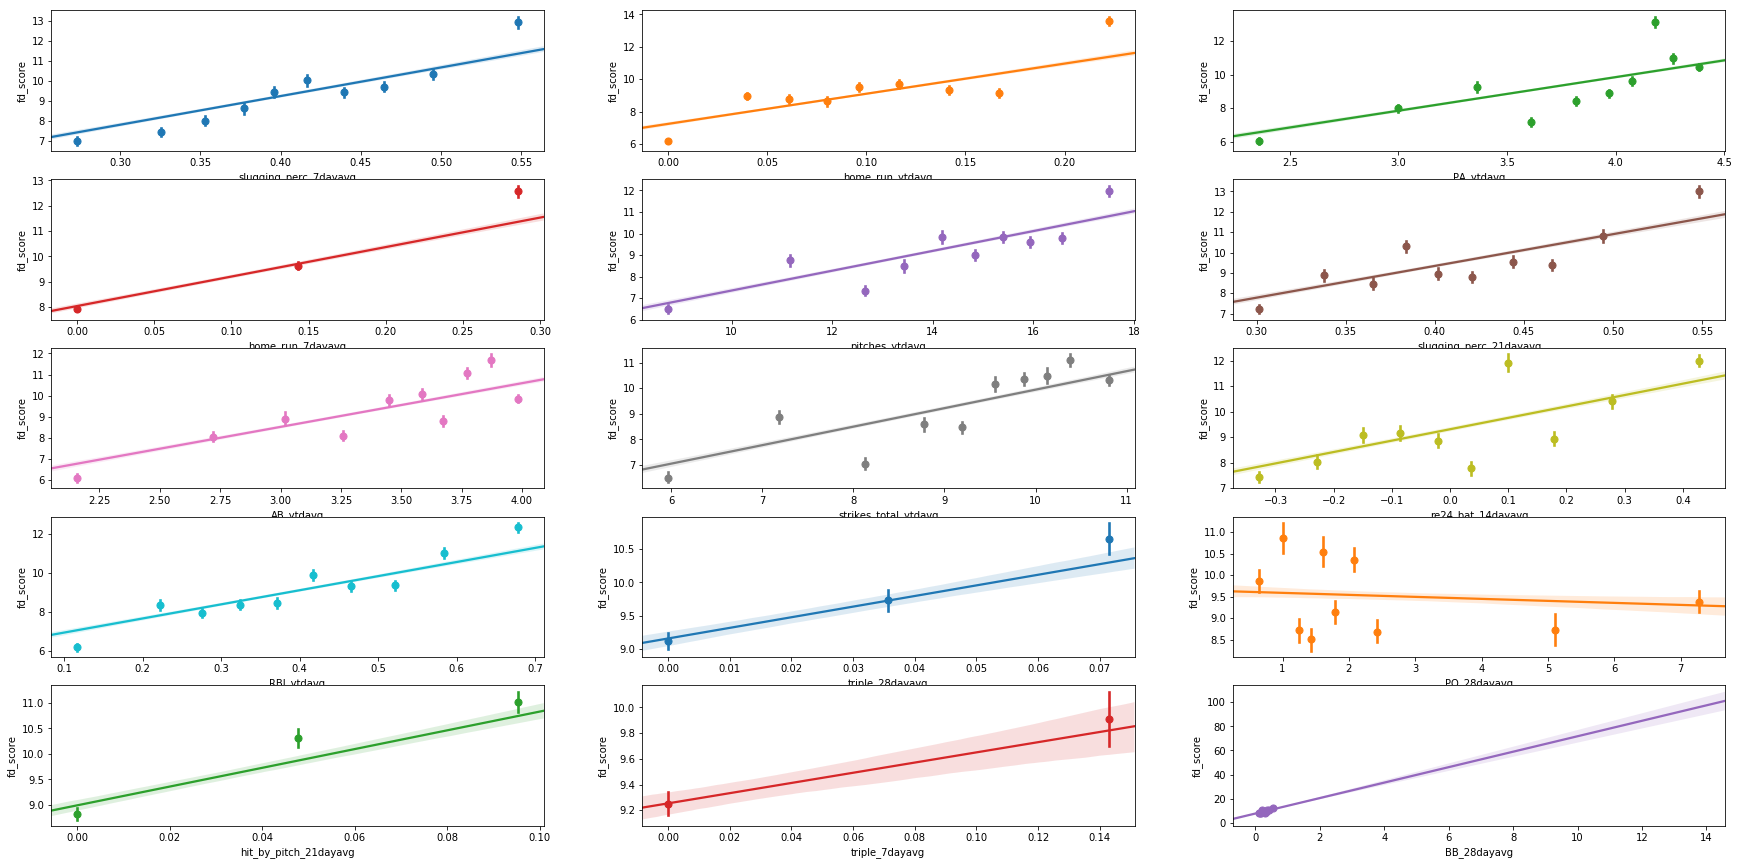

In [47]:
fig, ax = plt.subplots(5,3, figsize = (30,15), sharex=False)

axes = ax.ravel()

for i, col in enumerate(top_shap_b.columns):
    if i < len(axes):
        ax = sns.regplot(x=top_shap_b[col], y=top_shap_b['fd_score'], ax=axes[i], x_bins=10)
        ax.set(xlabel=col)

[<matplotlib.axis.XTick at 0x1c248819b0>,
 <matplotlib.axis.XTick at 0x1c27114518>,
 <matplotlib.axis.XTick at 0x1c20fe8470>,
 <matplotlib.axis.XTick at 0x1c2e75c208>,
 <matplotlib.axis.XTick at 0x1c257f2898>,
 <matplotlib.axis.XTick at 0x1c257f2b38>,
 <matplotlib.axis.XTick at 0x1c24ee8f28>]

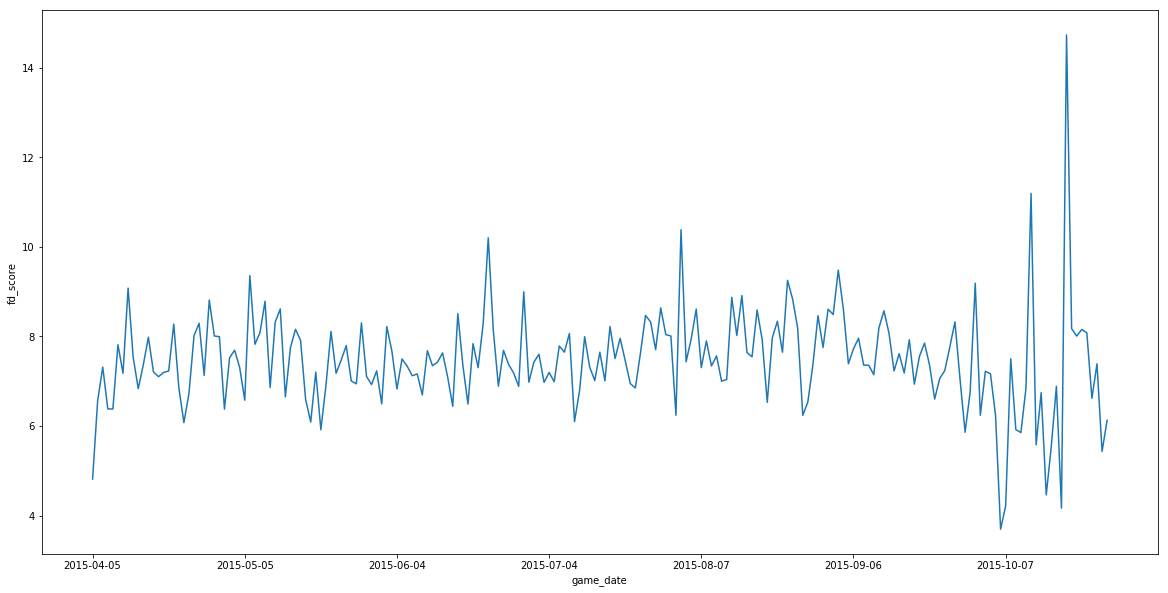

In [19]:
plt.subplots(figsize=(20,10))
ax = sns.lineplot(x=batting_df['game_date'], y=batting_df['fd_score'], ci=None)
ax.set_xticks(ticks=np.arange(0, len(batting_df['game_date'].unique()), 30))

<h3> Test Optimization Pipeline </h3>

In [149]:
import pybaseball
batter_ids = set(batting_df.player.unique())
lookup = pybaseball.playerid_reverse_lookup(list(batter_ids), key_type='bbref')

Gathering player lookup table. This may take a moment.


In [160]:
lookup.head(1)

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,abreu,jose,547989,abrej003,abreujo02,15676,2014.0,2018.0


In [1]:
import moneyball_optimizer

In [132]:
moneyball_optimizer.prep_optimization_actual_performance(game_date='2015-09-21')

In [184]:
# Historical Game Analysis (The best we could have done if we optimized on FD metrics)
rotoguru = pd.read_csv("mlb-dbd-2015.csv", sep=":", index_col=False)
rotoguru.columns = ['GID', 'MLB_ID','Name_Last_First','Name_First_Last',' P/H','Hand','Date','Team','Oppt','H/A','Game#','Game_ID','Gametime_ET','Team_score','Oppt_score','Home_Ump','Temp','Condition','W_speed','W_dir','ADI','prior_ADI','GS','GP','Pos','Order','Oppt_pitch_hand','Oppt_pich_GID','Oppt_pitch_MLB_ID','Oppt_pitch_Name','PA','wOBA_num','IP','W/L/S','QS','FD_points','DK_points','DD_points','SF_points','FD_salary','DK_salary','DD_salary','SF_salary','FD_pos','DK_pos','DD_pos','SF_pos']

rotoguru.drop(rotoguru.tail(1).index,inplace=True)

# Format Dates
rotoguru['Date'] = rotoguru['Date'].astype(str).str[:-2]
rotoguru['Date'] = pd.to_datetime(rotoguru['Date'])

# Create Last Name and First Name variables to match FD
rotoguru['Last Name'], rotoguru['First Name'] = zip(*rotoguru['Name_Last_First'].apply(lambda x: x.split(',')))

In [200]:
preds = pd.DataFrame(cv.id_preds, columns=['prediction', 'game_id'])
preds = pd.merge(preds, batting_df[['position', 'game_date', 'player', 'game_id']], on='game_id')
preds = preds.rename({'player' :'key_bbref'}, axis=1)
#bring in first and last name and mlbam - mlbam is used to identify players by rotoguru
preds = pd.merge(preds, lookup[['name_last', 'name_first', 'key_bbref', 'key_mlbam']], on='key_bbref')
#add nickname columns
preds['nickname'] = preds['name_last'] + preds['name_last']

#pick a random date
rotoguru_filtered = rotoguru[rotoguru['Date'] == '2015-09-21']
preds_filtered = preds[preds['game_date'] == '2015-09-21']

#join in other cols
preds_filtered = pd.merge(preds_filtered, rotoguru_filtered[['MLB_ID', 'FD_salary', 'Team', 'Oppt']], left_on='key_mlbam', right_on='MLB_ID')

In [207]:
#these are columns the optimizer looks for
preds_filtered['Played'] = 0
preds_filtered['Game'] = ""
preds_filtered['Injury Indicator'] = ""
preds_filtered['Injury Details'] = ""
preds_filtered['Tier'] = ""
#reset the column order to match what is expected by the optimizer
col_order = ['MLB_ID', 'position', 'name_first', 'nickname', 'name_last', 'prediction', 'Played', 'FD_salary', 'Game', 'Team', 'Oppt', 'Injury Indicator', 'Injury Details', 'Tier']
preds_filtered = preds_filtered[col_order]

#col names need to be exact, sigh
col_actual = ['Id', 'Position', 'First Name', 'Nickname', 'Last Name', 'FPPG', 'Played', 'Salary', 'Game', 'Team', 'Opponent', 'Injury Indicator', 'Injury Details', 'Tier']
preds_filtered.columns = col_actual


In [216]:
preds_filtered['Position'], preds_filtered['Position1'] = preds_filtered['Position'].str.split('-', 1).str

In [218]:
preds_filtered.drop('Position1', inplace=True, axis=1)

In [219]:
preds_filtered.to_csv('predictions_2015-09-21.csv', index=False, header=True)

In [17]:
import pandas as pd
sample = pd.read_csv('predictions_2015-09-21.csv')

In [65]:
sample['Game'] = sample['Team'] + '@' + sample['Opponent']
sample['Salary'] = sample['Salary'].astype(int)

In [23]:
sample.to_csv('predictions_2015-09-21.csv', header=True, index=False)

In [10]:
sample['Position'] = sample.Position.str.strip()

In [34]:
sample.loc[(sample['Position'] == 'CF') | (sample['Position'] == 'LF') | (sample['Position'] == 'RF'), 'Position'] = 'OF'

In [42]:
sample = pd.read_csv('predictions_2015-09-21.csv')

In [ ]:
import moneyball_optimizer
test = moneyball_optimizer.optimize_by_date(optimization_input='baseball_optimization_actual_performance.csv')

In [44]:
sample.Position.unique()

array(['OF', '3B', 'SS', 'C', 'P', '1B', '2B', 'DH'], dtype=object)

In [38]:
batting_df, pitching_df = dh.load_data()

Trying to load csvs!


In [39]:
batting_df['game_date'].max()

'2018-10-01'

In [40]:
batting_df = batting_df[batting_df['game_date'] < '2018-08-01']

In [41]:
batting_df.to_csv('batting_df_master.csv', header=True, index=False)

In [44]:
batting_df[batting_df['player'] == 'aranovi01']

,game_id,away_team,home_team,game_date,start_time,attendance,game_situation,player,team,AB,...,wpa_bat_pos,wpa_bat_neg,re24_bat,PO,A,details,position,day_of_week,year,stadium
74035,2017-10-01Citizens Bank Parkaranovi01,New York Mets,Philadelphia Phillies,2017-10-01,3:11 p.m.,"25,754","Day Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Sunday,2017.0,Citizens Bank Park
74075,2017-09-30Citizens Bank Parkaranovi01,New York Mets,Philadelphia Phillies,2017-09-30,7:08 p.m.,"25,138","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Saturday,2017.0,Citizens Bank Park
74131,2017-09-27Citizens Bank Parkaranovi01,Washington Nationals,Philadelphia Phillies,2017-09-27,7:07 p.m.,"17,642","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,1,0,,Wednesday,2017.0,Citizens Bank Park
74197,2017-09-25Citizens Bank Parkaranovi01,Washington Nationals,Philadelphia Phillies,2017-09-25,7:07 p.m.,"17,026","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Monday,2017.0,Citizens Bank Park
74334,2017-09-21Citizens Bank Parkaranovi01,Los Angeles Dodgers,Philadelphia Phillies,2017-09-21,1:07 p.m.,"18,735","Day Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Thursday,2017.0,Citizens Bank Park
74367,2017-09-20Citizens Bank Parkaranovi01,Los Angeles Dodgers,Philadelphia Phillies,2017-09-20,7:08 p.m.,"20,175","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Wednesday,2017.0,Citizens Bank Park
74424,2017-09-18Citizens Bank Parkaranovi01,Los Angeles Dodgers,Philadelphia Phillies,2017-09-18,7:07 p.m.,"16,690","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Monday,2017.0,Citizens Bank Park
74495,2017-09-16Citizens Bank Parkaranovi01,Oakland Athletics,Philadelphia Phillies,2017-09-16,7:07 p.m.,"24,290","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Saturday,2017.0,Citizens Bank Park
74636,2017-09-13Citizens Bank Parkaranovi01,Miami Marlins,Philadelphia Phillies,2017-09-13,7:06 p.m.,"16,745","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Wednesday,2017.0,Citizens Bank Park
74710,2017-09-12Citizens Bank Parkaranovi01,Miami Marlins,Philadelphia Phillies,2017-09-12,7:07 p.m.,"16,439","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Tuesday,2017.0,Citizens Bank Park
